#Импортируем нужные библиотеки, нейросеть будем писать на PyTorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, auc

#Загрузим дасет [Emotions dataset for NLP](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp?select=train.txt)

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/test.txt', names=['text', 'emotion'], sep=';')
val_df = pd.read_csv('/content/drive/MyDrive/val.txt', names=['text', 'emotion'], sep=';')
test_df = pd.read_csv('/content/drive/MyDrive/test.txt', names=['text', 'emotion'], sep=';')

train_df.head()

,text,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


Посмотрим распределение на классы эмоций:

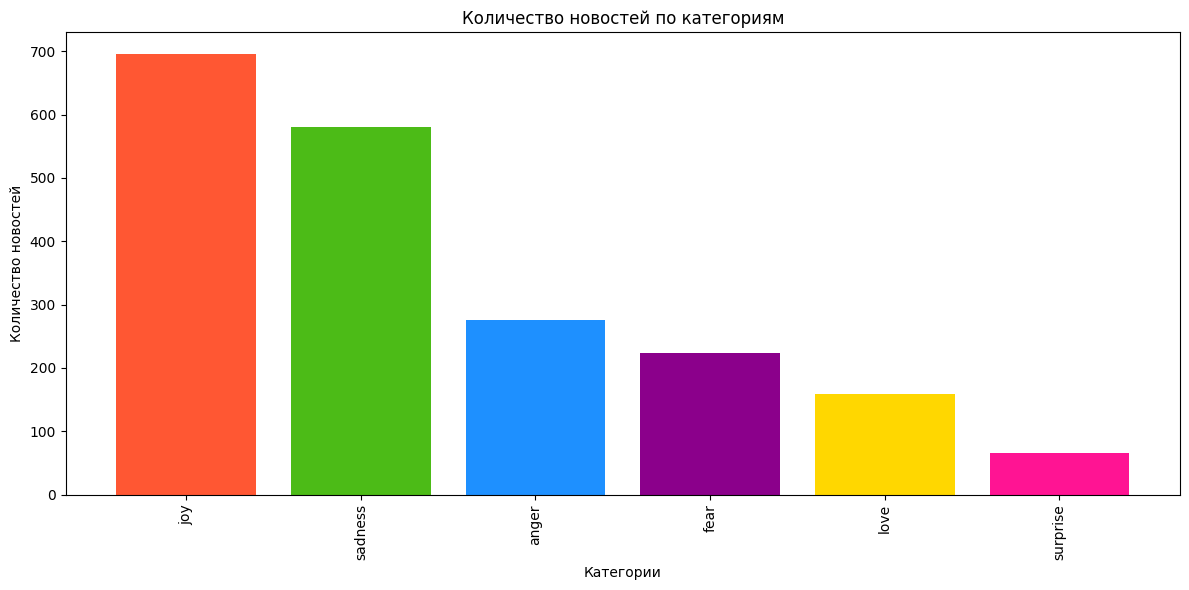

In [ ]:
categories = train_df.emotion.value_counts().index
counts = train_df.emotion.value_counts().values

# Создаем столбчатый график
plt.figure(figsize=(12, 6))
plt.bar(categories, counts, color=['#FF5733', '#4CBB17', '#1E90FF', '#8B008B', '#FFD700', '#FF1493'])

# Добавляем название графика и метки осей
plt.title('Количество новостей по категориям')
plt.xlabel('Категории')
plt.ylabel('Количество новостей')

# Поворачиваем метки по оси X, чтобы они не пересекались
plt.xticks(rotation=90)

# Отображаем график
plt.tight_layout()
plt.show()

#Загрузка предобученной модели BERT

In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#Создадим Dataset класс для нашего набора данных

In [ ]:
# посмотрим на грубую оценку длины предложения
df_len = train_df['text'].apply(lambda x: len(x.split()))

df_len.describe()

count    2000.000000
mean       19.154000
std        11.012353
min         3.000000
25%        10.000000
50%        17.000000
75%        26.000000
max        61.000000
Name: text, dtype: float64

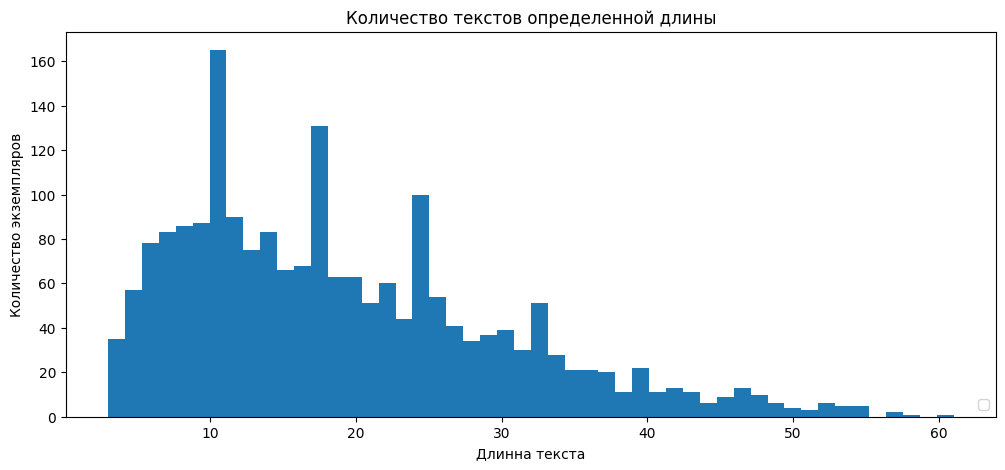

In [ ]:
# Создаем гистограмму
plt.figure(figsize=(12, 5))
plt.hist(df_len, bins=50)

# Добавляем название графика и метки осей
plt.xlabel('Длинна текста')
plt.ylabel('Количество экземпляров')
plt.title('Количество текстов определенной длины')

# Отображаем график
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Гиперпараметры модели
# выбреем максимальную длинну слова 64, так как почти все текста будут иметь такую длину

MAX_LEN = 64
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 16
LEARNING_RATE = 1e-05

Закодируем целевую переменную (категории эмоций)

In [ ]:
le = LabelEncoder()
train_df['emotion'] = le.fit_transform(train_df['emotion'])
val_df['emotion'] = le.transform(val_df['emotion'])
test_df['emotion'] = le.transform(test_df['emotion'])
val_df.head()

,text,emotion
0,im feeling quite sad and sorry for myself but ...,4
1,i feel like i am still looking at a blank canv...,4
2,i feel like a faithful servant,3
3,i am just feeling cranky and blue,0
4,i can have for a treat or if i am feeling festive,2


In [ ]:
# определеим веса классов, так как датасет несбалансированный
class_weights = {class_label: 1 / (count / len(train_df) * 100) for class_label, count in train_df.emotion.value_counts().items()}

print(class_weights)

{2: 0.02877697841726619, 4: 0.034423407917383825, 0: 0.07272727272727272, 1: 0.08928571428571427, 3: 0.12578616352201258, 5: 0.303030303030303}


In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.loc[index, 'text'])
        emotion = self.df.loc[index, 'emotion']

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'emotion': torch.tensor(emotion, dtype=torch.long)
        }

Создадим DataLoader

In [ ]:
train_dataset = EmotionDataset(train_df, tokenizer, MAX_LEN )
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE ,
                          shuffle=True)

val_dataset = EmotionDataset(val_df, tokenizer, MAX_LEN)
val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE )

#Инициализация нейронной сети BertClassifier на основе BERT

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, bert_model_name, dropout=0.2):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(768, 64)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 6)

    def forward(self, input_ids, attention_mask):

        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout1(pooled_output)
        output = self.fc1(pooled_output)
        output = self.relu(output)
        output = self.dropout2(output)
        logits = self.fc2(output)

        return logits

#Обучение сети

In [ ]:
def plot_train_history(train_losses, train_f1_scores, val_losses, val_f1_scores):
    """
    Функция отрисовки процесса обучения модели
    """
    plt.figure(figsize=(16, 6))

    # Loss на обучающей выборке
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    # F1-мера на обучающей и валидационной выборках
    plt.subplot(1, 2, 2)
    plt.plot(train_f1_scores, label='Train F1 Score')
    plt.plot(val_f1_scores, label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Train and Validation F1 Score')
    plt.legend()

    plt.show()


In [ ]:
def generate_classification_report(model, eval_dataloader, device):
    """
    Функция выводящая отчет по всей модели

    """

    y_true = []  # Список для хранения истинных меток
    y_pred = []  # Список для хранения предсказанных меток
    y_scores = []  # Список для хранения вероятностей для ROC-AUC

    # Переводим модель в режим оценки
    model.eval()

    with torch.no_grad():
        for data in eval_dataloader:
            # переносим данные на device
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['emotion'].to(device)

            # получаем предсказанные значения

            outputs = model(input_ids, attention_mask)

            # Применяем софтмакс для получения вероятностей классов
            probabilities = torch.softmax(outputs, dim=1)

            # Получаем предсказанные классы как индексы с наибольшей вероятностью
            _, predicted = torch.max(probabilities, 1)

            # Преобразуем тензоры в списки
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Получаем вероятности для ROC-AUC
            y_scores.extend(probabilities.cpu().numpy())

    # Генерируем отчет с использованием classification_report
    report = classification_report(y_true, y_pred)

    # Calculate micro-average ROC-AUC
    micro_fpr, micro_tpr, _ = roc_curve(np.array(y_true), np.array(y_scores)[:, 1], pos_label=1)
    micro_roc_auc = auc(micro_fpr, micro_tpr)

    # Calculate macro-average ROC-AUC
    n_classes = len(np.unique(y_true))
    macro_fpr = dict()
    macro_tpr = dict()
    macro_roc_auc = dict()
    for i in range(n_classes):
        macro_fpr[i], macro_tpr[i], _ = roc_curve(np.array(y_true) == i, np.array(y_scores)[:, i])
        macro_roc_auc[i] = auc(macro_fpr[i], macro_tpr[i])

    # Calculate macro-average ROC-AUC by averaging over classes
    macro_roc_auc = np.mean(list(macro_roc_auc.values()))

    # Print ROC-AUC scores
    print(f'Micro-average ROC-AUC: {micro_roc_auc}')
    print(f'Macro-average ROC-AUC: {macro_roc_auc}')

    plt.figure(figsize=(8, 6))
    lw = 2
    for i in range(n_classes):
        plt.plot(macro_fpr[i], macro_tpr[i], lw=lw, label=f'Class {i} (area = {macro_roc_auc:0.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return report


In [ ]:
def calculate_f1_score(preds, labels):
    pred_flat = torch.argmax(preds, dim=1).cpu().numpy()
    labels_flat = labels.cpu().numpy()
    f1 = f1_score(labels_flat, pred_flat, average='weighted')
    return f1

def train_and_evaluate(model, train_data_loader, val_data_loader, optimizer, criterion, device, num_epochs):
    model.to(device)

    train_losses = []  # Список для хранения потерь на обучающем наборе данных
    val_losses = []    # Список для хранения потерь на валидационном наборе данных
    train_f1_scores = []  # Список для хранения F1-оценок на обучающем наборе данных
    val_f1_scores = []    # Список для хранения F1-оценок на валидационном наборе данных

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_f1 = 0.0

        for batch in tqdm(train_data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['emotion'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_f1 += calculate_f1_score(outputs, labels)

        avg_train_loss = train_loss / len(train_data_loader)
        avg_train_f1 = train_f1 / len(train_data_loader)

        model.eval()
        val_loss = 0.0
        val_f1 = 0.0

        with torch.no_grad():
            for batch in tqdm(val_data_loader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['emotion'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_f1 += calculate_f1_score(outputs, labels)

        avg_val_loss = val_loss / len(val_data_loader)
        avg_val_f1 = val_f1 / len(val_data_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_f1_scores.append(avg_train_f1)
        val_f1_scores.append(avg_val_f1)

        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Train Loss: {avg_train_loss:.4f} | Train F1 Score: {avg_train_f1:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f} | Val F1 Score: {avg_val_f1:.4f}')
        print('-' * 50)
    # Визуализация результатов
    plot_train_history(train_losses, train_f1_scores, val_losses, val_f1_scores)

    report = generate_classification_report(model, val_data_loader, device)
    print(report)

    return model


100%|██████████| 125/125 [00:08<00:00, 14.83it/s]


Epoch 1/16
Train Loss: 1.8079 | Train F1 Score: 0.2259
Val Loss: 1.7878 | Val F1 Score: 0.1985
--------------------------------------------------


100%|██████████| 125/125 [00:07<00:00, 15.66it/s]


Epoch 2/16
Train Loss: 1.7900 | Train F1 Score: 0.2623
Val Loss: 1.7741 | Val F1 Score: 0.2796
--------------------------------------------------


100%|██████████| 125/125 [00:08<00:00, 15.03it/s]


Epoch 3/16
Train Loss: 1.7487 | Train F1 Score: 0.3223
Val Loss: 1.6640 | Val F1 Score: 0.4435
--------------------------------------------------


100%|██████████| 125/125 [00:08<00:00, 14.65it/s]


Epoch 4/16
Train Loss: 1.6109 | Train F1 Score: 0.4466
Val Loss: 1.4825 | Val F1 Score: 0.4815
--------------------------------------------------


100%|██████████| 125/125 [00:08<00:00, 15.00it/s]


Epoch 5/16
Train Loss: 1.4431 | Train F1 Score: 0.5063
Val Loss: 1.2780 | Val F1 Score: 0.5945
--------------------------------------------------


100%|██████████| 125/125 [00:08<00:00, 15.54it/s]


Epoch 6/16
Train Loss: 1.2255 | Train F1 Score: 0.5613
Val Loss: 1.0736 | Val F1 Score: 0.6442
--------------------------------------------------


100%|██████████| 125/125 [00:08<00:00, 15.29it/s]


Epoch 7/16
Train Loss: 0.9988 | Train F1 Score: 0.6698
Val Loss: 0.8981 | Val F1 Score: 0.7586
--------------------------------------------------


100%|██████████| 125/125 [00:08<00:00, 14.72it/s]


Epoch 8/16
Train Loss: 0.8367 | Train F1 Score: 0.7445
Val Loss: 0.7709 | Val F1 Score: 0.7884
--------------------------------------------------


100%|██████████| 125/125 [00:08<00:00, 14.68it/s]


Epoch 9/16
Train Loss: 0.6900 | Train F1 Score: 0.8223
Val Loss: 0.6892 | Val F1 Score: 0.8182
--------------------------------------------------


100%|██████████| 125/125 [00:08<00:00, 15.33it/s]


Epoch 10/16
Train Loss: 0.5416 | Train F1 Score: 0.8863
Val Loss: 0.5859 | Val F1 Score: 0.8613
--------------------------------------------------


100%|██████████| 125/125 [00:08<00:00, 15.61it/s]


Epoch 11/16
Train Loss: 0.4130 | Train F1 Score: 0.9310
Val Loss: 0.5286 | Val F1 Score: 0.8727
--------------------------------------------------


100%|██████████| 125/125 [00:08<00:00, 15.02it/s]


Epoch 12/16
Train Loss: 0.3530 | Train F1 Score: 0.9532
Val Loss: 0.4966 | Val F1 Score: 0.8795
--------------------------------------------------


100%|██████████| 125/125 [00:08<00:00, 14.75it/s]


Epoch 13/16
Train Loss: 0.2831 | Train F1 Score: 0.9647
Val Loss: 0.4964 | Val F1 Score: 0.8669
--------------------------------------------------


100%|██████████| 125/125 [00:08<00:00, 15.00it/s]


Epoch 14/16
Train Loss: 0.2337 | Train F1 Score: 0.9706
Val Loss: 0.5177 | Val F1 Score: 0.8864
--------------------------------------------------


100%|██████████| 125/125 [00:08<00:00, 15.58it/s]


Epoch 15/16
Train Loss: 0.1962 | Train F1 Score: 0.9808
Val Loss: 0.5509 | Val F1 Score: 0.8843
--------------------------------------------------


100%|██████████| 125/125 [00:08<00:00, 15.24it/s]


Epoch 16/16
Train Loss: 0.1732 | Train F1 Score: 0.9869
Val Loss: 0.5841 | Val F1 Score: 0.8716
--------------------------------------------------


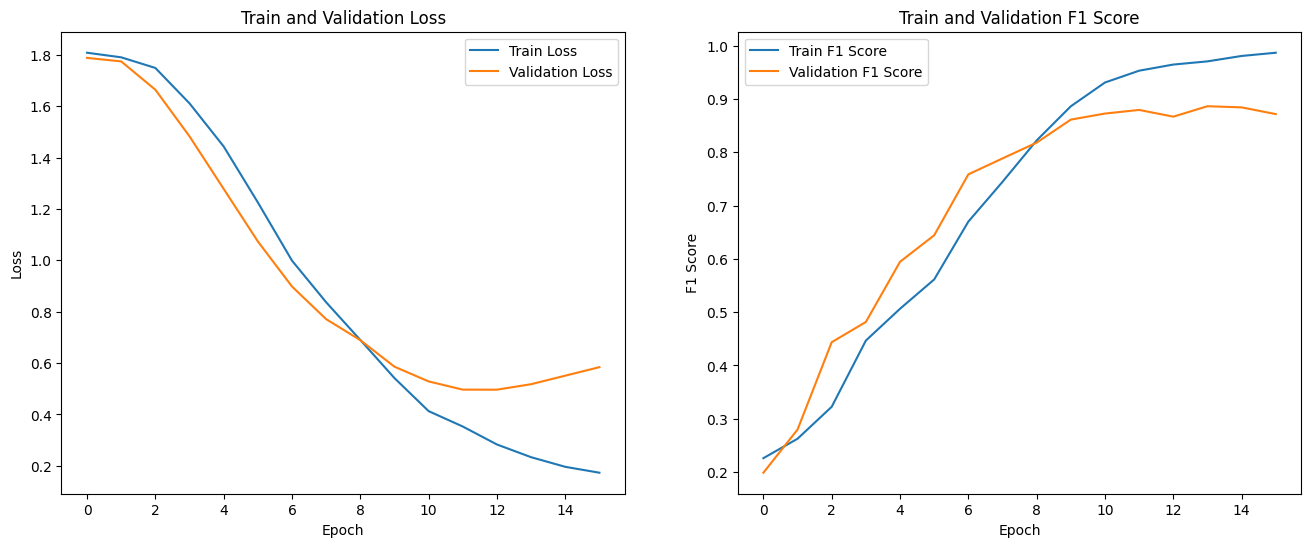

Micro-average ROC-AUC: 0.98118351905787
Macro-average ROC-AUC: 0.9716444283011554


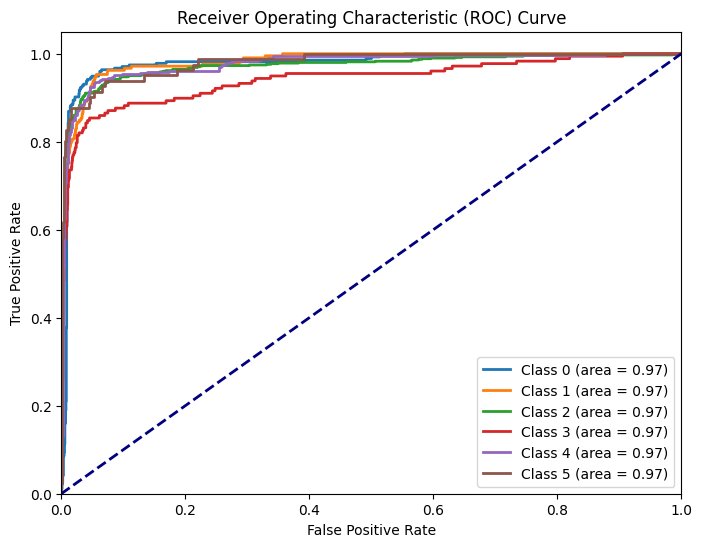

              precision    recall  f1-score   support

           0       0.74      0.95      0.83       275
           1       0.76      0.85      0.80       212
           2       0.93      0.91      0.92       704
           3       0.87      0.70      0.78       178
           4       0.95      0.85      0.89       550
           5       0.80      0.83      0.81        81

    accuracy                           0.87      2000
   macro avg       0.84      0.85      0.84      2000
weighted avg       0.88      0.87      0.87      2000



In [ ]:
model = BertClassifier('bert-base-uncased', dropout=0.5)

# определяем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

 # создадим веса для каждого класса
class_weights_tensor = torch.FloatTensor([class_weights[i] for i in range(len(class_weights))]).to(device)

# используем Кросс энтропию для задачи многоклассовой классификации
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# определяем оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# перемещаем model на device
model.to(device)

bert = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, EPOCHS)


#Тестим

In [ ]:
def predict(model, test_data):
    # Создадим EmotionDataset и DataLoader на основе test_data
    test = EmotionDataset(test_data, tokenizer, MAX_LEN)
    test_dataloader = DataLoader(test, batch_size=VALID_BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.to(device)

    model.eval()

    pred = []
    target = []

    for data in tqdm(test_dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['emotion'].to(device)
        target.append(labels)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
            pred.append(outputs)

    # Копируем и объединяем предсказания
    pred = np.concatenate([t.cpu().numpy() for t in pred], axis=0)
    # Копируем и объединяем истинные метки
    target = np.concatenate([t.cpu().numpy() for t in target], axis=0)

    average_f1_score = calculate_f1_score(torch.tensor(pred), torch.tensor(target))
    report = classification_report(np.argmax(pred, axis=1), target)

    print(f'\n  F1 Score на тесте: {average_f1_score:.3f}')
    print(report)

In [ ]:
predict(bert, test_df)

100%|██████████| 125/125 [00:08<00:00, 15.56it/s]


  F1 Score на тесте: 0.978
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       296
           1       0.99      0.98      0.98       227
           2       0.99      0.98      0.99       698
           3       0.95      0.97      0.96       155
           4       0.96      1.00      0.98       557
           5       1.00      0.99      0.99        67

    accuracy                           0.98      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.98      0.98      0.98      2000

